In [3]:
import phizz
import pandas as pd

In [5]:
spg_genotypes = pd.read_csv('hpo_term_analysis/omim_codes.csv')
omim_codes = spg_genotypes.OMIM

In [21]:
hpo_terms = {
    'hpo_term': [],
    'description': []
}

for omim in omim_codes:
    prepend = 'OMIM:'
    omim = str(omim).strip('.0')
    omim = prepend + omim
    if not omim == 'OMIM:nan':
        query_dict =  phizz.query_disease([omim])
    else:
        continue
    for result in query_dict:
        hpo_terms['hpo_term'].append(result['hpo_term'])
        hpo_terms['description'].append(result['description'])
        
hpo_terms_df = pd.DataFrame(data=hpo_terms).drop_duplicates('hpo_term')
hpo_terms_df.head(10)

,hpo_term,description
0,HP:0003487,Babinski sign
1,HP:0003743,Genetic anticipation
2,HP:0001347,Hyperreflexia
3,HP:0003419,Low back pain
4,HP:0002166,Impaired vibration sensation in the lower limbs
5,HP:0000639,Nystagmus
6,HP:0003587,Insidious onset
7,HP:0010550,Paraplegia
8,HP:0000726,Dementia
9,HP:0003676,Progressive


In [27]:
with open('gene_lists/panelapp_gene_list.txt', 'r') as f:
    gene_list = f.readlines()
    
gene_list = [x.strip('\n') for x in gene_list]
gene_list[:10]

['SPART',
 'WASHC5',
 'ADAR',
 'AFG3L2',
 'AIMP1',
 'ALDH18A1',
 'ALS2',
 'AP4B1',
 'AP4E1',
 'AP4M1']

In [95]:
gene_phenotype_matrix = pd.DataFrame(columns=[hpo_term for hpo_term in hpo_terms_df.hpo_term], index=gene_list)
gene_phenotype_matrix.head()

,HP:0003487,HP:0003743,HP:0001347,HP:0003419,HP:0002166,HP:0000639,HP:0003587,HP:0010550,HP:0000726,HP:0003676,...,HP:0000763,HP:0007083,HP:0000519,HP:0002500,HP:0003552,HP:0001760,HP:0003701,HP:0001123,HP:0002411,HP:0002486
SPART,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WASHC5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AFG3L2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AIMP1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
from intermine.webservice import Service
service = Service("http://www.humanmine.org/humanmine/service")
template = service.get_template('Gene_Disease_HPO')

In [ ]:
present_hpo_terms = {}

for gene in gene_list:
    rows = template.rows(
        A = {"op": "LOOKUP", "value": gene, "extra_value": ""}
    )
    present_hpo_terms_for_gene = []
    for row in rows:
        row_list = list(row.itervalues())
        present_hpo_terms_for_gene.append(row_list[-2])
        
    present_hpo_terms[gene] = present_hpo_terms_for_gene
    
"""
of type: 
{'gene_name': ['list', 'of', 'hpo_terms'],}
"""

In [124]:
import numpy as np

for row in gene_phenotype_matrix.iterrows():
    gene_name = row[0]
    present_terms = present_hpo_terms[gene_name]
    column_names = list(gene_phenotype_matrix.columns.values)
    for column_name in column_names:
        if column_name in present_terms:
            row[1][column_name] = np.int64(1.0)
        elif column_name not in present_terms:
            row[1][column_name] = np.int64(0.0)
        else:
            # barf!
            raise Error

In [125]:
gene_phenotype_matrix.head()

,HP:0003487,HP:0003743,HP:0001347,HP:0003419,HP:0002166,HP:0000639,HP:0003587,HP:0010550,HP:0000726,HP:0003676,...,HP:0000763,HP:0007083,HP:0000519,HP:0002500,HP:0003552,HP:0001760,HP:0003701,HP:0001123,HP:0002411,HP:0002486
SPART,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WASHC5,1,0,1,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ADAR,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AFG3L2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
AIMP1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [126]:
t_gene_phenotype_matrix = gene_phenotype_matrix.transpose()
t_gene_phenotype_matrix.head()

,SPART,WASHC5,ADAR,AFG3L2,AIMP1,ALDH18A1,ALS2,AP4B1,AP4E1,AP4M1,...,ZFYVE27,ATXN10,ATXN1,ATXN2,ATXN3,ATXN7,CACNA1A,FXN,HTT,PPP2R2B
HP:0003487,1,1,0,1,0,1,1,1,1,1,...,1,0,1,0,1,1,0,1,0,0
HP:0003743,0,0,0,0,0,1,0,0,0,0,...,0,1,0,1,1,0,1,0,0,0
HP:0001347,1,1,0,0,0,1,1,1,1,1,...,0,1,1,0,0,1,1,0,1,1
HP:0003419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HP:0002166,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [145]:
gene_gene_matrix_mult_df = gene_phenotype_matrix.dot(t_gene_phenotype_matrix)
gene_gene_matrix_mult_df

,SPART,WASHC5,ADAR,AFG3L2,AIMP1,ALDH18A1,ALS2,AP4B1,AP4E1,AP4M1,...,ZFYVE27,ATXN10,ATXN1,ATXN2,ATXN3,ATXN7,CACNA1A,FXN,HTT,PPP2R2B
SPART,23,9,2,6,3,9,11,8,9,7,...,5,4,5,3,4,4,5,4,2,4
WASHC5,9,20,3,4,3,12,10,5,7,5,...,6,4,5,5,4,3,4,3,2,2
ADAR,2,3,10,3,4,6,2,4,5,3,...,1,2,2,3,2,3,5,2,1,1
AFG3L2,6,4,3,22,3,8,9,6,4,3,...,2,6,9,9,10,7,7,4,3,5
AIMP1,3,3,4,3,9,5,2,5,5,5,...,0,1,0,1,1,0,3,2,1,0
ALDH18A1,9,12,6,8,5,34,11,12,11,10,...,6,8,7,7,6,7,9,6,3,3
ALS2,11,10,2,9,2,11,23,7,7,6,...,4,4,6,6,6,5,6,5,1,3
AP4B1,8,5,4,6,5,12,7,31,20,19,...,3,3,4,3,4,4,6,3,2,2
AP4E1,9,7,5,4,5,11,7,20,33,20,...,4,5,4,1,3,4,7,3,4,4
AP4M1,7,5,3,3,5,10,6,19,20,29,...,3,3,2,0,3,2,4,2,4,2


In [158]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


float_matrix = gene_gene_matrix_mult_df[gene_gene_matrix_mult_df.columns].astype(float)
float_matrix_sub_1 = float_matrix - 1 

In [161]:
float_matrix_sub_1.head()

,SPART,WASHC5,ADAR,AFG3L2,AIMP1,ALDH18A1,ALS2,AP4B1,AP4E1,AP4M1,...,ZFYVE27,ATXN10,ATXN1,ATXN2,ATXN3,ATXN7,CACNA1A,FXN,HTT,PPP2R2B
SPART,22.0,8.0,1.0,5.0,2.0,8.0,10.0,7.0,8.0,6.0,...,4.0,3.0,4.0,2.0,3.0,3.0,4.0,3.0,1.0,3.0
WASHC5,8.0,19.0,2.0,3.0,2.0,11.0,9.0,4.0,6.0,4.0,...,5.0,3.0,4.0,4.0,3.0,2.0,3.0,2.0,1.0,1.0
ADAR,1.0,2.0,9.0,2.0,3.0,5.0,1.0,3.0,4.0,2.0,...,0.0,1.0,1.0,2.0,1.0,2.0,4.0,1.0,0.0,0.0
AFG3L2,5.0,3.0,2.0,21.0,2.0,7.0,8.0,5.0,3.0,2.0,...,1.0,5.0,8.0,8.0,9.0,6.0,6.0,3.0,2.0,4.0
AIMP1,2.0,2.0,3.0,2.0,8.0,4.0,1.0,4.0,4.0,4.0,...,-1.0,0.0,-1.0,0.0,0.0,-1.0,2.0,1.0,0.0,-1.0


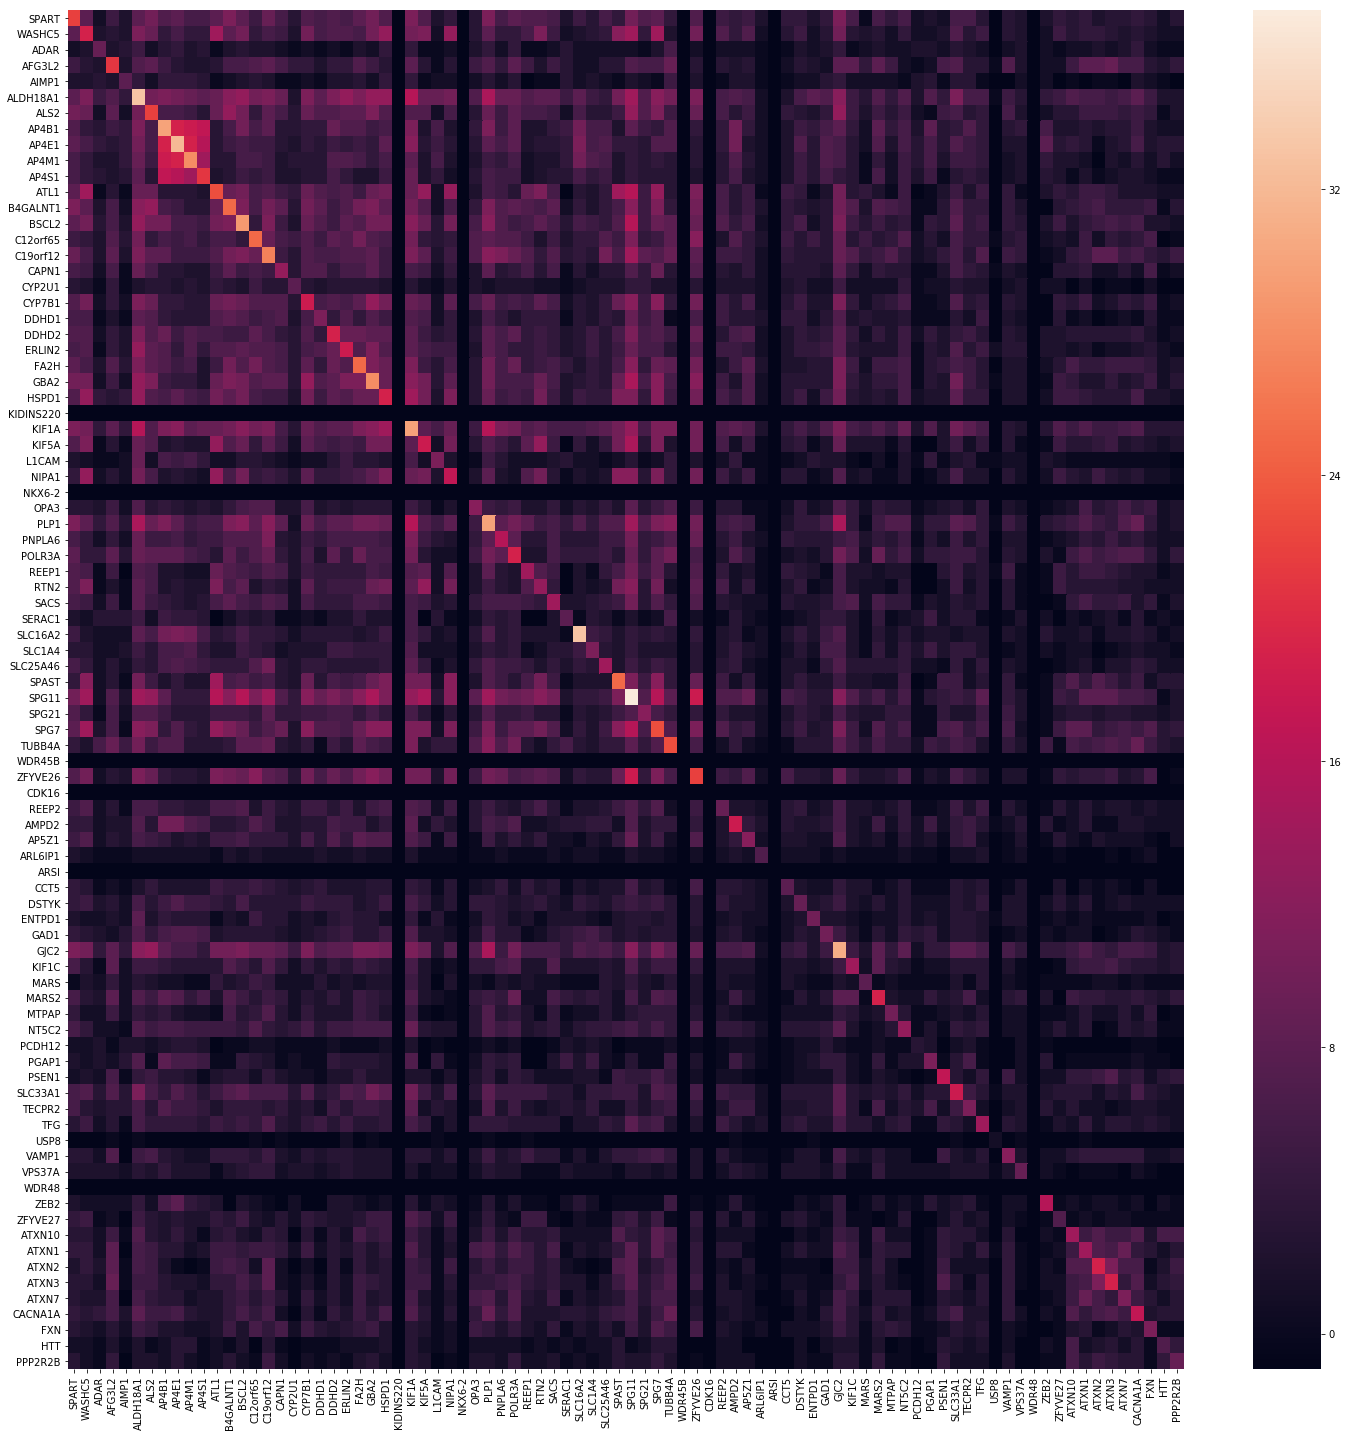

In [170]:
a4_dims = (25, 25)
fig, ax = plt.subplots(figsize=a4_dims)

plt1 = sns.heatmap(float_matrix_sub_1)

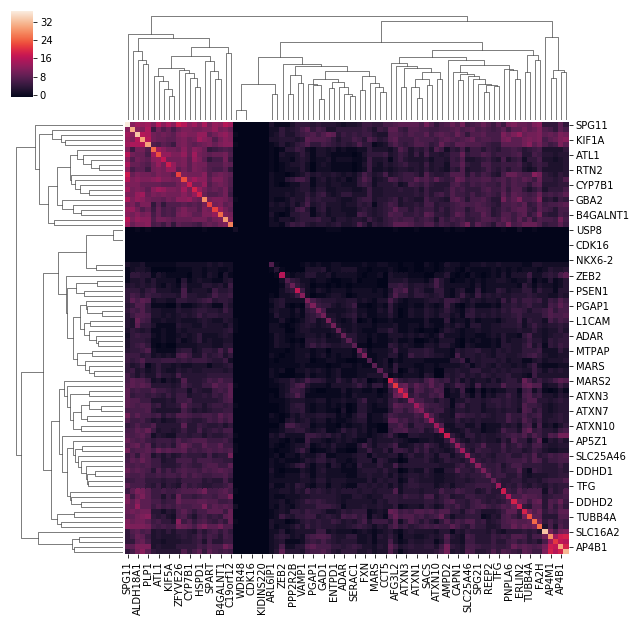

In [172]:
plt2 = sns.clustermap(float_matrix_sub_1)